## Starter with pytorch

In [98]:
## https://www.kaggle.com/abhinand05/in-depth-guide-to-convolutional-neural-networks

 Import Libraries

In [1]:
import numpy as np
import pandas as pd

import os

import matplotlib.pyplot as plt
plt.style.use('ggplot')

import cv2

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

## Load Dataset

In [2]:
train_df = pd.read_csv("train.csv")

In [3]:
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [8]:
# 타겟률 확인

0.7506285714285714

파이토치에 데이터를 활용하기 위해 데이터 전처리 <br>
torch.utils.data.Dataset class 활용하기

In [10]:
train_path = './train/'
test_path = './test/'

In [7]:
# 데이터를 가공하기 위한 Dataset 클래스

class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir='./', transform=None):
        super().__init__() # Dataset 클래스의 속성을 상속
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name, label = self.df[index]
        img_path = os.path.join(self.data_dir, img_name)
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [8]:
# 적용할 transform을 사전에 정의
# PIL로 변형한 후에 -> randomFip하고 -> randomRotation한 뒤에 -> Tensor로 바꾸고 -> Normalize

transforms_train = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(10),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [11]:
# train_data를 pytorch가 이해할 수 있는 클래스로 변형

train_data = CreateDataset(df_data=train_df, 
                           data_dir=train_path, 
                           transform=transforms_train)

In [16]:
# Set Batch Size
batch_size = 64

# percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

In [20]:
# Create samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [21]:
# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler = train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler = valid_sampler)

In [22]:
# transforms test dataset
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [23]:
sample_sub = pd.read_csv("sample_submission.csv")

In [26]:
# Create test data
sample_sub = pd.read_csv("sample_submission.csv")
test_data = CreateDataset(df_data=sample_sub, 
                         data_dir = test_path,
                         transform=transforms_test)

In [27]:
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

## Visualize

In [78]:
classes = ['No Cactus', 'Cactus']

In [32]:
def imshow(img):
    '''
    helper function to un-normalize and display an image
    '''
    
    # unnormalize
    img = img/2 + 0.5
    # convert from tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

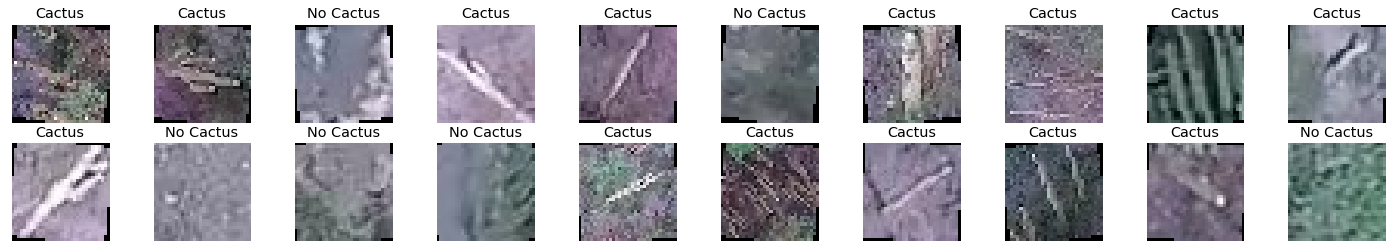

In [79]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # 1 batch가 64로 설정되어 있으므로 64로 설정

fig = plt.figure(figsize=(25,4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

## 모형 아키텍쳐 만들기

In [84]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(128*2*2, 512)
        self.fc2 = nn.Linear(512, 2)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = x.view(-1, 128*2*2)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [85]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print("CUDA is not avaliable. Training on CPU....")
else:
    print("CUDA is not avaliable. Training on CPU....")

CUDA is not avaliable. Training on CPU....


In [87]:
model = CNN()
print(model)

if train_on_gpu: model.cuda()

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=512, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [89]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)

In [93]:
n_epochs = 30
valid_loss_min = np.Inf

In [94]:
train_losses = []
valid_losses = []

In [97]:
for epochs in range(1, n_epochs+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    # training phase
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * data.size(0)
        
    # valid phase
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item() * data.size(0)
        
    # calcaulate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    # print log
    print("Epoch : {} \t Training Loss : {:.6f} \t Validation Loss : {:.6f}".format(epochs, train_loss, valid_loss))
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'best_model.pt')
        valid_loss_min = valid_loss

Epoch : 1 	 Training Loss : 0.098942 	 Validation Loss : 0.085494
Validation loss decreased (inf --> 0.085494).  Saving model ...
Epoch : 2 	 Training Loss : 0.082057 	 Validation Loss : 0.072792
Validation loss decreased (0.085494 --> 0.072792).  Saving model ...
Epoch : 3 	 Training Loss : 0.067998 	 Validation Loss : 0.072888
Epoch : 4 	 Training Loss : 0.065731 	 Validation Loss : 0.061393
Validation loss decreased (0.072792 --> 0.061393).  Saving model ...
Epoch : 5 	 Training Loss : 0.055629 	 Validation Loss : 0.049520
Validation loss decreased (0.061393 --> 0.049520).  Saving model ...
Epoch : 6 	 Training Loss : 0.051825 	 Validation Loss : 0.056636
Epoch : 7 	 Training Loss : 0.046588 	 Validation Loss : 0.041719
Validation loss decreased (0.049520 --> 0.041719).  Saving model ...
Epoch : 8 	 Training Loss : 0.041909 	 Validation Loss : 0.046401
Epoch : 9 	 Training Loss : 0.038294 	 Validation Loss : 0.040590
Validation loss decreased (0.041719 --> 0.040590).  Saving model .

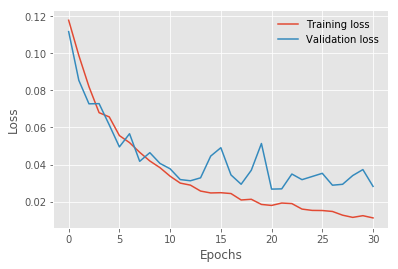

In [99]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [100]:
# Load best parameters
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

## Predictions

In [102]:
# Turning off gradient
model.eval()

preds = []
for batch_i, (data, target) in enumerate(test_loader):
    output = model(data)
    
    pr = output[:,1].detach().cpu().numpy()
    for i in pr:
        preds.append(i)
        
sample_sub['has_cactus'] = preds

In [104]:
sample_sub.has_cactus.describe()

count    4000.000000
mean        2.993620
std         5.274184
min        -5.936989
25%        -1.690951
50%         3.443352
75%         6.379778
max        24.104330
Name: has_cactus, dtype: float64